# Training and Evaluating LDA Models

## Training

This is the the heart of our LDA Pipeline. After loading the preprocessed data from [the previous notebook](02.2_LDA-Preprocessing.ipynb), we will use the sklearn implementation of LDA to train our model. We will also use the GridSearchCV class to find the best hyperparameters for our model.

Other popular Python-Implementations of LDA include [gensim](https://radimrehurek.com/gensim/models/ldamodel.html) and [lda](https://pypi.org/project/lda/).

All of these adhere to a very similar API and differ only in minor details. Gensim in particular is a very popular library for topic modeling with a lot of additional functionality, so you might want to check it out.

### Loading Preprocessed Data

In [1]:
import json

with open('../data/articles/train.preprocessed.json', 'r') as f:
    data = json.load(f)

with open('../data/articles/test.preprocessed.json', 'r') as f:
    data_test = json.load(f)

with open('../data/articles/train.json', 'r') as f:
    labels = json.load(f)
    labels = [doc['label'] for doc in labels]
    labels_map = {label: i for i, label in enumerate(set(labels))}
    labels = [labels_map[label] for label in labels]


### Setting up the Pipeline

The sklearn LDA-implementation ingests a document-term-matrix (DTM) as input. This is a matrix where each row represents a document and each column represents a term. The values in the matrix represent the frequency of the term in the document.

To create a DTM from our data, we will use the gensim dictionary. This class takes a list of strings as input, generates a vocabulary as an intermediate step, and outputs a DTM.
It allows us to prune that vocabulary by setting a minimum and maximum document frequency for the terms in the vocabulary. This is useful to remove very rare terms that are likely to be typos or very common terms that are unlikely to be informative.

In [2]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents and filter out frequent and rare words.
dictionary = Dictionary(data)
dictionary.filter_extremes(no_below=30, no_above=0.85)

# Build the Document Term Matrix (DTM)
dtm = [dictionary.doc2bow(doc) for doc in data]

N, V = len(dtm), len(dictionary)
print("Found a vocabulary of {} unique terms in {} documents".format(V, N))


Found a vocabulary of 4442 unique terms in 2977 documents


### Fitting the Model

To perform LDA, we need to choose three hyperparameters. The first is the number of topics we want to find, $K$. The second is the $\alpha$ parameter, which controls the sparsity of the document-topic matrix. The third is the $\eta$ parameter, which controls the sparsity of the topic-term matrix. 

Both sklearn and gensim allow users to ommit the latter two parameters, in which case they are set to a default value of $1/K$. While this is a good starting point, we will learn how to fine-tune these parameters later on.

$K$ has no such obvious default value, which, without further knowledge of our data, forces us to choose a random starting point. Even though we know our particular dataset consists of eight sections, we will start with $K=10$ and see how the model performs. Later on, we will learn how to evaluate the model and use that to choose a better value for $K$.

In [3]:
# For better performance, we use the multicore implementation of LDA
from gensim.models import LdaMulticore
import numpy as np

# Explicitly setting the number of topics
K = 10

# Alpha and eta would default to different values
# We explicitly set them to 1 in order to demonstrate the effect of symmetric priors
alpha = np.ones((K))
eta = 1

# Passes determines the number of training passes through the corpus
# A larger number might yield slightly better results, linearly increases training time
passes = 1

# Train the model on the corpus.
lda_model_naiv = LdaMulticore(dtm, K, id2word=dictionary,
                              alpha=alpha, eta=eta, passes=passes, random_state=42)


## Evaluation

Evaluating topic models is a difficult task. 
Typically, there are no ground truth labels, so we cannot use metrics like precision and recall. 
Instead, besides manual inspection, we usually have to rely on metrics that measure the *coherence* of the topics. 
These metrics are based on the assumption that a good topic model will produce topics that are both distinct and human interpretable.

### Manual Inspection

It is useful to manually explore the topics that the model has found. To do this, we will use the `show_topics` method of the gensim LdaModel.

In [26]:
def print_topics(lda_model, num_words=8):
    topics = lda_model.show_topics(
        num_topics=lda_model.num_topics, num_words=num_words, formatted=False)

    for id, topic in topics:
        print("Topic #{}".format(id), end=": ")
        for word, freq in topic:
            print(word, end=" ")
        print()


print_topics(lda_model_naiv)


Topic #0: I year people use company new like United 
Topic #1: I year people company New use like time 
Topic #2: year time I use New like company York 
Topic #3: year I people company like find include work 
Topic #4: I year company time people team like work 
Topic #5: I year like people time company use Trump 
Topic #6: I year like company people work day new 
Topic #7: I year time people like New new include 
Topic #8: year I like people new day use company 
Topic #9: I year company like work New include use 


The generated topics all look very similar. *I*, *year*, and *company* are among the top five words of almost all topics, which makes for poor interpretability and distinctiveness.

To mitigate this, we could take two approaches. 
The first is to add words like *I* to the stopword list, effectively removing them from the vocabulary.
While this makes sense for some words and is common practice, *company* or *year* appear to actually carry important semantic information.

The second approach is to tune the hyperparameters of the model.
In particular, we can try to increase the sparsity of the topic-word matrix by decreasing $\eta$, as well as increasing the document-topic sparsity by decreasing $\alpha$. We also increase the number of passes to ten.

In [29]:
alpha = np.ones((K)) / K
eta = 1 / K
passes = 10

lda_model_better_hp = LdaMulticore(dtm, K, id2word=dictionary,
                                   alpha=alpha, eta=eta, passes=passes, random_state=42)

print_topics(lda_model_better_hp)


Topic #0: right European country Justice political court year government 
Topic #1: patient drug people health I year use percent 
Topic #2: China United North chinese States Korea country american 
Topic #3: official government year people police kill child family 
Topic #4: company Facebook I Google use people app like 
Topic #5: Trump president House election vote state I President 
Topic #6: company year percent business million billion market executive 
Topic #7: vaccine people variant dose child virus booster state 
Topic #8: year study scientist find like University virus researcher 
Topic #9: I year team time like game play win 


We can clearly see that the topics have become more distinct. While *company* still appears in multiple topics, more meaningful word-combinations like *vaccine*, *virus*, and *variant* or *China*, *chineses*, *North*, and *Korea* have surfaced.

*North Korea* is a curious example at this point, as both words appear indepent, yet clearly belong to a single semantic unit. The [chapter on advanced methods](LDA-04-Advanced.ipynb) will demonstrate how one can deal with this.

We also notice a stark increase in execution time. This is because we have increased the number of passes, which means that the model will be trained on the data ten times.

### Visualizing the Topics

Besides reading through the most prominent words of each topic, visualizing the size and similarity of the topics can be another useful tool for manual inspection.

pyLDAvis is the most common Python library for such visualizations of LDA models. It is based on the R package LDAvis, which is described in [this paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

The visualization consists of two parts. The left part shows a two-dimensional projection of the topics. The right part shows the top 30 terms for the selected topic. The size of the terms is proportional to the frequency of the term in the corpus. The distance between the terms is proportional to the distance between the terms in the topic-term matrix.

In [30]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_better_hp, dtm, dictionary)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.090164  0.008547       1        1  14.253308
8      0.119466 -0.035588       2        1  13.216811
5     -0.115977  0.000901       3        1  12.460069
6      0.027351  0.101540       4        1  12.120325
1      0.058250 -0.045660       5        1  11.964275
4      0.012407  0.092397       6        1   9.735558
3     -0.052691 -0.003114       7        1   9.229420
0     -0.092877 -0.006743       8        1   6.621218
2     -0.029881  0.021146       9        1   5.737191
7     -0.016212 -0.133427      10        1   4.661825, topic_info=         Term         Freq        Total Category  logprob  loglift
1556  company  5014.000000  5014.000000  Default  30.0000  30.0000
2443  vaccine  1199.000000  1199.000000  Default  29.0000  29.0000
514     Trump  2850.000000  2850.000000  Default  28.0000  28.0000
733   patient  1538.000000  1538.000000  Default  27.0000  27.0000
484     China  1169.000000  1169.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
796      case   174.756562  2117.852882  Topic10  -5.6124   0.5710
235       new   179.205691  3593.325596  Topic10  -5.5872   0.0675
557   country   171.793629  2346.887801  Topic10  -5.6295   0.4512
332      time   173.036956  4240.892672  Topic10  -5.6223  -0.1333
230     month   168.314758  2272.216522  Topic10  -5.6499   0.4631

[681 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3126      1  0.961382  2014krasnaya
3836      3  0.179488    2015credit
3836      4  0.747867    2015credit
3836      5  0.029915    2015credit
4344      1  0.025762       2015the
...     ...       ...           ...
352       6  0.057969          year
352       7  0.081028          year
352       8  0.048307          year
352       9  0.046504          year
352      10  0.027567          year

[4379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 6, 7, 2, 5, 4, 1, 3, 8])

We can clearly see multiple clusters of very close topics.
This is a good example of how the visualization can hint us towards finding the correct number of topics, which appear to be below 10 in our case.

To perform the search for the optimal number more rigorously, we will now turn to the coherence metric.

### Coherence

Coherence is a measure of the semantic similarity of the terms in a topic. A good coherence score indicates that the terms within a topic are more probable to coocure within the topic than outside of it.

To generate the optimal number of topics, we have to compute the LDA-Model for every number of topics we are interested in. Usually, one starts by computing the model for a small number of topics and then increases the number of topics until the coherence score starts to decrease.

In [5]:
from tqdm import tqdm
from gensim.models import CoherenceModel, LdaMulticore
from os import makedirs
from os.path import join
import matplotlib.pyplot as plt

plt.style.use('ggplot')

model_path = join("..", "data", "lda-models")
makedirs(model_path, exist_ok=True)

number_of_topics = [2, 4, 8, 12, 16, 32, 64, 128]
coherence_scores = []


In [31]:
pbar = tqdm(number_of_topics, ncols=100)
for K in pbar:
    # We need to adjust alpha and eta for the number of topics
    alpha = np.ones((K)) / K
    eta = 1 / K

    pbar.set_description("Computing LDA")
    lda_model = LdaMulticore(dtm, K, id2word=dictionary,
                             alpha=alpha, eta=eta, passes=4, random_state=123)
    lda_model.save(join(model_path, "lda_model_{}.model".format(K)))

    pbar.set_description("Computing Coherence")
    cm_cv = CoherenceModel(model=lda_model, corpus=dtm,
                           texts=data_test,
                           dictionary=dictionary, coherence='c_v')
    cm_umass = CoherenceModel(model=lda_model, corpus=dtm,
                              texts=data_test,
                              dictionary=dictionary, coherence='u_mass')
    cm_uci = CoherenceModel(model=lda_model, corpus=dtm,
                            texts=data_test,
                            dictionary=dictionary, coherence='c_uci')
    cm_npmi = CoherenceModel(model=lda_model, corpus=dtm,
                             texts=data_test,
                             dictionary=dictionary, coherence='c_npmi')

    coherence_scores.append({
        'K': K,
        'c_v': cm_cv.get_coherence(),
        'u_mass': cm_umass.get_coherence(),
        'c_uci': cm_uci.get_coherence(),
        'c_npmi': cm_npmi.get_coherence()
    })


Computing Coherence: 100%|████████████████████████████████████████████| 8/8 [04:13<00:00, 31.69s/it]


We plot the coherence score for the different numbers of topics and choose the number of topics that maximizes the coherence score.

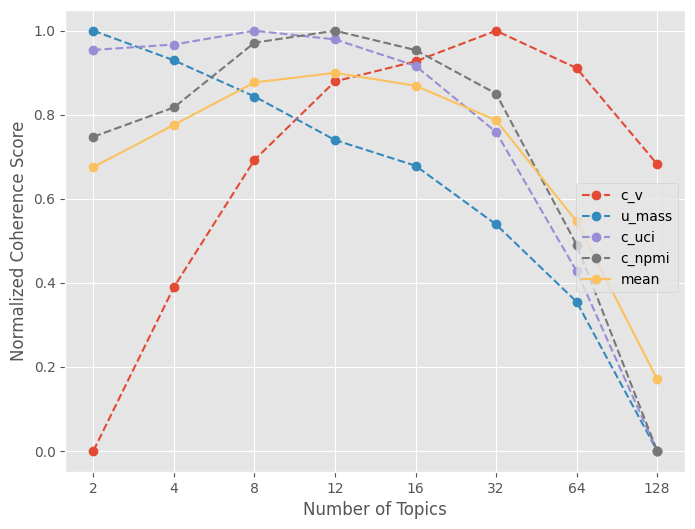

In [32]:
fig, ax0 = plt.subplots(figsize=(8, 6), dpi=100)
mean_score = np.zeros(len(coherence_scores))

# Normalize and plot the scores
for metric in ['c_v', 'u_mass', 'c_uci', 'c_npmi']:
    min_score = min([score[metric] for score in coherence_scores])
    max_score = max([score[metric] for score in coherence_scores])
    normalized_score = [(score[metric] - min_score) /
                        (max_score - min_score) for score in coherence_scores]

    mean_score += normalized_score
    ax0.plot(normalized_score, '--', label=metric, marker='o')

mean_score /= 4
ax0.plot(mean_score, label='mean', marker='o')

ax0.set_ylabel("Normalized Coherence Score")
ax0.set_xlabel("Number of Topics")
ax0.set_xticks(range(len(number_of_topics)))
ax0.set_xticklabels([str(K) for K in number_of_topics])

fig.legend(loc='center right', bbox_to_anchor=(.9, 0.5))


This graph fits our previous knowledge: The first dataset has eight topics, which also yields a high coherence score.
However, the disagreement between the different measures of coherence is quite substantial, with $c_v$ being the most obvious outlier. While $c_v$ has some known issues, the disagreement between the remaining measures, in particular for a small number of topics, still poses a problem.

If we were to rely on the coherence score alone to choose the number of topics, we would need to dig deeper into the differences between the measures and their respective strengths and weaknesses.
There is no clear consensus on which measure is the best, so we will not go into detail here.


### Ground-Truth Comparison

We also plot the confusion matrix of the optimal model against the true labels to further investigate the model's performance.
This step is only possible because we have access to the true labels in this case. In general, we will have to rely on manual inspection and coherence scores.

 88%|████████████████████████████████████████████████████████▉        | 7/8 [00:21<00:03,  3.03s/it]


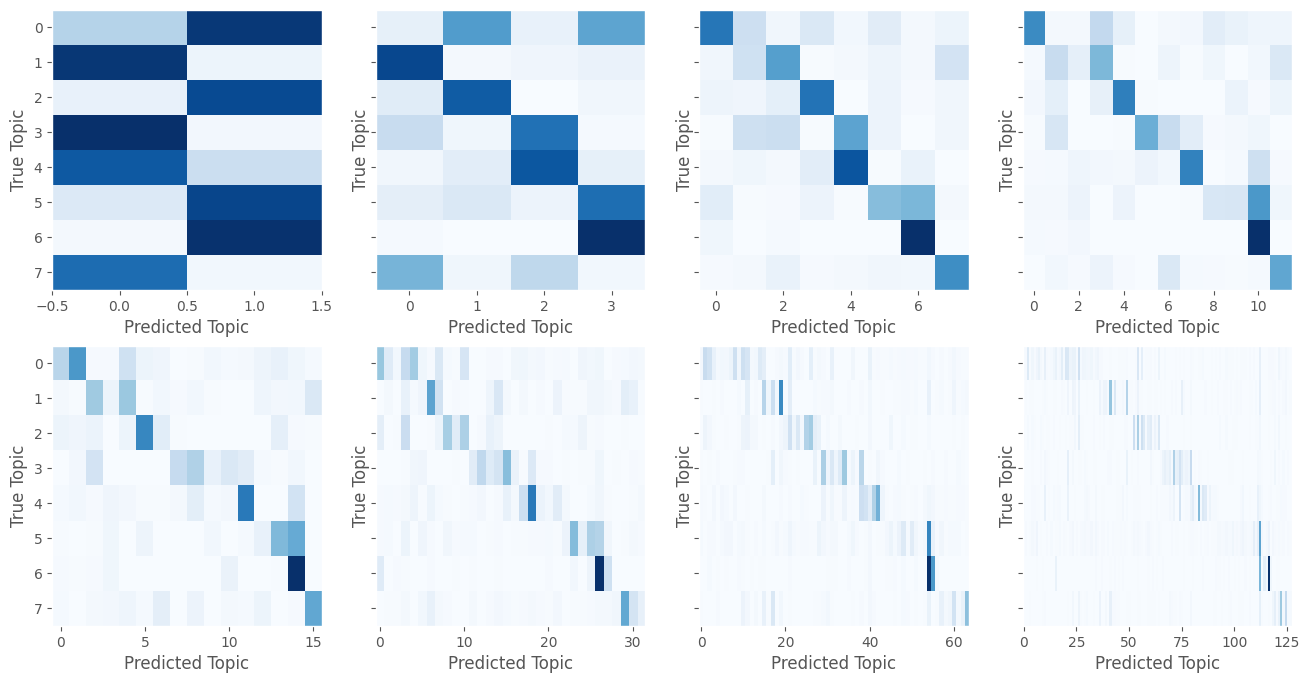

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('ggplot')

fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=100, sharey=True)
axs = axs.flatten()

conf_matricies = []


def get_topic(lda, bow):
    preds = lda.get_document_topics(bow, minimum_probability=0.0)
    probs = [prob for _, prob in preds]
    index = [index for index, _ in preds]
    return index[np.argmax(probs)]


for ax, nr in zip(axs, tqdm(number_of_topics, ncols=100)):
    T_true, T_pred = 8, nr
    conf = np.zeros((T_true, T_pred))
    conf_matricies.append(conf)

    model = LdaMulticore.load(
        join(model_path, "lda_model_{}.model".format(nr)))

    topics = [get_topic(model, doc) for doc in dtm]

    for label_gt, label_pred in zip(labels, topics):
        conf[label_gt][label_pred] += 1

    conf_top_pred = np.argmax(conf, axis=0)
    conf_order_by_pred = np.argsort(conf_top_pred)
    conf_ordered_by_pred = conf[:, conf_order_by_pred]

    ax.imshow(conf_ordered_by_pred, cmap='Blues', aspect='auto',
              interpolation='nearest', vmin=0)
    ax.set_xlabel("Predicted Topic")
    ax.set_ylabel("True Topic")
    ax.grid(False)


Text(0, 0.5, 'Confusion Loss')

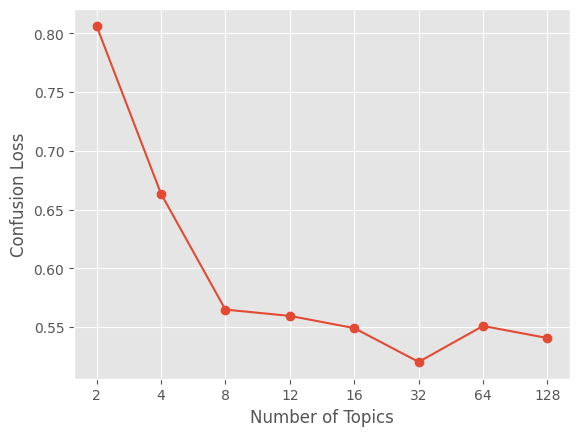

In [10]:
from helper.ConfusionLoss import confusion_loss

scores = [confusion_loss(conf) for conf in conf_matricies]
plt.plot(scores, marker='o')
plt.xticks(range(len(number_of_topics)), [str(K) for K in number_of_topics])

plt.xlabel("Number of Topics")
plt.ylabel("Confusion Loss")


### Grid-Search for $\alpha$ and $\eta$

While the number of topics is the most important hyperparameter, we already saw the impact the $\alpha$ and $\eta$ parameters can have on the quality of the topics.

To find the optimal values for these parameters, we will use the GridSearchCV class. This class takes a model and a dictionary of hyperparameters as input and computes the model for all combinations of the hyperparameters. It then returns the model with the best score.

In theory, one should optimize all three parameters at once. However, this is computationally very expensive. Therefore, we will fix the number of topics to the optimal value we found in the previous step and only optimize $\alpha$ and $\eta$.

In [38]:
import numpy as np

K = 12
array_alpha = np.logspace(-5, 5, 3, base=2) * 1 / K
array_eta = np.logspace(-5, 5, 3, base=2) * 1 / K
results = np.zeros((len(array_alpha), len(array_eta)))


def compute_coherence(alpha, eta):
    lda_model = LdaMulticore(
        dtm, K, id2word=dictionary, alpha=alpha, eta=eta, passes=4, random_state=123)
    cm = CoherenceModel(model=lda_model, corpus=dtm,
                        texts=data_test,
                        dictionary=dictionary, coherence='c_v')
    return cm.get_coherence()


print("Starting grid search")
pbar = tqdm(total=len(array_alpha) * len(array_eta),
            ncols=100, position=0, leave=True)

for i, alpha in enumerate(array_alpha):
    for j, eta in enumerate(array_eta):
        pbar.set_description("alpha: {:.4f}, eta: {:.4f}".format(alpha, eta))
        results[i, j] = compute_coherence(alpha, eta)
        pbar.update()


Starting grid search


alpha: 2.6667, eta: 2.6667: 100%|█████████████████████████████████████| 9/9 [02:25<00:00, 16.66s/it]

We can now plot the results of the grid-search. The plot shows the coherence score for the different values of $\alpha$ and $\eta$.
The optimal values are the ones that maximize the coherence score.

Optimal parameters: alpha=0.08333333333333333, eta=2.6666666666666665


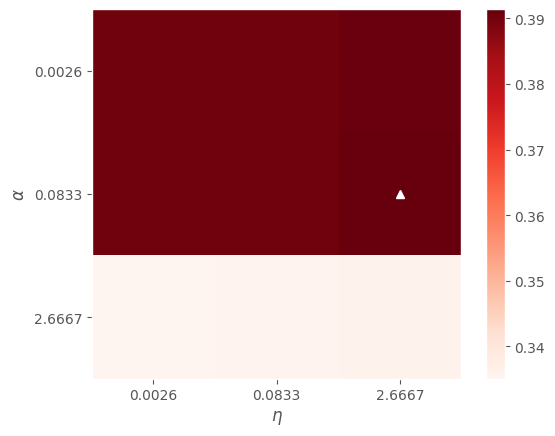

In [43]:
optimal = np.unravel_index(np.argmax(results), results.shape)
optimal_parameters = (array_alpha[optimal[0]], array_eta[optimal[1]])

print("Optimal parameters: alpha={}, eta={}".format(*optimal_parameters))

plt.imshow(results, cmap='Reds', interpolation='nearest')
plt.grid(False)

plt.xticks(range(len(array_eta)), ["{:.4f}".format(eta) for eta in array_eta])
plt.yticks(range(len(array_alpha)), [
           "{:.4f}".format(alpha) for alpha in array_alpha])

plt.xlabel("$\\eta$")
plt.ylabel("$\\alpha$")

plt.plot(optimal[1], optimal[0], '^', color='white')
plt.colorbar()


### Exploring the Optimal Model

Using the optimal parameters, we can again use pyLDAvis to visualize the topics.
Further, the gensim model itself has convenience methods to explore the topics. In particular, we can use the `show_topics` method to print the top terms for each topic.

In [46]:
K = 12
lda_model = LdaMulticore(dtm, K,
                         passes=6, id2word=dictionary, alpha=optimal_parameters[0], eta=optimal_parameters[1])

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, dtm, dictionary, mds='tsne')


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      -14.015471   75.918236       1        1  16.822163
10      31.323429   11.665681       2        1  13.082231
1      117.394608   12.337144       3        1  12.935829
2      -64.512024  145.739182       4        1   9.360718
11      -4.546557  -66.978821       5        1   8.908394
7      -50.031754    5.878662       6        1   8.005618
0       76.312469  -67.821350       7        1   7.681587
8      -84.385811  -80.216568       8        1   6.926779
9       78.578720   87.244019       9        1   5.597739
6     -107.363396   74.070152      10        1   4.721489
3     -134.795898   -5.612703      11        1   3.773574
5       26.011642  152.273987      12        1   2.183878, topic_info=         Term         Freq        Total Category  logprob  loglift
33          I  7696.000000  7696.000000  Default  30.0000  30.0000
2443  vaccine   869.000000   869.000000  Default  29.0000  29.0000
1556  company  4264.000000  4264.000000  Default  28.0000  28.0000
933     virus  1151.000000  1151.000000  Default  27.0000  27.0000
514     Trump  2831.000000  2831.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
512    States    61.149968  2288.523204  Topic12  -5.9041   0.2017
518    United    61.779110  2567.513443  Topic12  -5.8939   0.0969
218      like    63.971888  4259.521560  Topic12  -5.8590  -0.3744
715    health    57.256927  1380.233456  Topic12  -5.9699   0.6416
43        New    56.526239  3426.782284  Topic12  -5.9828  -0.2806

[755 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
754       1  0.023354      0
754       2  0.723973      0
754       3  0.015569      0
754       4  0.023354      0
754       5  0.031139      0
...     ...       ...    ...
1091      8  0.075849  young
1091      9  0.035928  young
1091     10  0.055888  young
1091     11  0.017299  young
1091     12  0.065203  young

[6528 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 11, 2, 3, 12, 8, 1, 9, 10, 7, 4, 6])

All topics are now very distinct and interpretable. We can clearly see that the model has found the eight sections of the dataset, while subdividing some of them even further.

In [47]:
print_topics(lda_model, 10)


Topic #0: company use app I like Apple people technology new Facebook 
Topic #1: company year case law business court executive Justice I Facebook 
Topic #2: patient I year people New study health work York like 
Topic #3: North Korea United States nuclear China missile South country official 
Topic #4: Trump president election House year President government I official vote 
Topic #5: vaccine people dose booster year child Johnson shot age company 
Topic #6: I like people year time work use Facebook know student 
Topic #7: year percent company market rate new price million investor high 
Topic #8: virus people drug test health new infection coronavirus variant study 
Topic #9: space people kill attack year police official government force astronaut 
Topic #10: I year team game time play win like player come 
Topic #11: year find like time study scientist I know University water 


That's it!